<a href="https://colab.research.google.com/github/wanburana/AT82.01-brain-project-group-4/blob/main/Jirasak/code/cnnrnn_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementing the paper [Emotion Recognition from Multi-Channel EEG through Parallel Convolutional Recurrent Neural Network](https://ieeexplore.ieee.org/document/8489331) with with some modification to dropout, learning rate, L2 regularization to prevent overfitting

In [ ]:
!gdown --id 1OLUTwrQIhitY16HrEDJBPz2Sd7tSYqRi # cnn_preprocessed
!gdown --id 1-78ZfPixbqA1jLVGFXtrNCJ9pq4Cgpz9 # rnn_preprocessed

!gdown --id 1sacOlggvbtn5ATVkrb3DJqfpSg7eI3Fo # label

Downloading...
From: https://drive.google.com/uc?id=1OLUTwrQIhitY16HrEDJBPz2Sd7tSYqRi
To: /content/eeg_preprocessed_cnn_memmap.dat
100% 3.19G/3.19G [00:21<00:00, 148MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-78ZfPixbqA1jLVGFXtrNCJ9pq4Cgpz9
To: /content/eeg_preprocessed_rnn_memmap.dat
100% 1.26G/1.26G [00:12<00:00, 104MB/s]


In [ ]:
import os
from glob import glob
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

In [ ]:
label_df = pd.read_csv('deap_label_raw.csv')
label_df_binarized = (label_df >= 5).astype('int')
label_df_binarized



,valence,arousal,dominance,liking
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,0,1,1,1
4,1,0,1,1
...,...,...,...,...
1275,0,1,1,0
1276,0,1,1,0
1277,0,1,1,0
1278,0,1,0,0


In [ ]:
cnn_memmap_path = 'eeg_preprocessed_cnn_memmap.dat'
cnn_data = np.memmap(cnn_memmap_path, dtype='float32', mode='r', shape=(1280, 60, 9, 9, 128))

rnn_memmap_path = 'eeg_preprocessed_rnn_memmap.dat'
rnn_data = np.memmap(rnn_memmap_path, dtype='float32', mode='r', shape=(1280, 60, 32, 128))

cnn_data_reshaped = cnn_data.reshape(-1, 9, 9, 128)
rnn_data_reshaped = rnn_data.reshape(-1, 32, 128)

In [ ]:
# select first 25 participants as training data
# and last 7 participants as testing data

train_participants = 25
test_participants = 32 - train_participants
clip_per_participants = 40
segment_per_sample = 60

test_samples = test_participants*clip_per_participants*segment_per_sample

# train_cnn_data = cnn_data_reshaped()

In [ ]:
# instead of train_test_split on the data, we do it on index
# and then assign the index to our data later

expand_indices = np.arange(len(cnn_data_reshaped))
train_indices, test_indices = train_test_split(expand_indices, test_size=test_samples, shuffle=False)

In [ ]:
# expand 

valence_label = label_df_binarized['valence'].values
arousal_label = label_df_binarized['arousal'].values

# repeat the label by 60 to match the new data
valence_label_tiled = np.tile(valence_label.reshape(-1, 1), reps=[60]).reshape(-1)
arousal_label_tiled = np.tile(arousal_label.reshape(-1, 1), reps=[60]).reshape(-1)

In [ ]:
train_cnn_data = cnn_data_reshaped[train_indices]
test_cnn_data = cnn_data_reshaped[test_indices]

train_rnn_data = rnn_data_reshaped[train_indices]
test_rnn_data = rnn_data_reshaped[test_indices]

train_valence_label = valence_label_tiled[train_indices]
test_valence_label = valence_label_tiled[test_indices]

In [ ]:
class CNNRNNDatasetV2(Dataset):
    def __init__(self, cnn_data, rnn_data, label):
        self.cnn_data = cnn_data
        self.rnn_data = rnn_data
        self.label = label

    def __len__(self):
        return len(self.cnn_data)

    def __getitem__(self, idx):
        cnn_feature = np.array(self.cnn_data[idx])
        rnn_feature = np.array(self.rnn_data[idx])

        target = np.array(self.label[idx])

        return (torch.from_numpy(cnn_feature), torch.from_numpy(rnn_feature)), torch.from_numpy(target)    

In [ ]:
BATCH_SIZE = 128

In [ ]:
train_ds = CNNRNNDatasetV2(train_cnn_data, train_rnn_data, train_valence_label)
test_ds = CNNRNNDatasetV2(test_cnn_data, test_rnn_data, test_valence_label)

train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
class RNNCNN(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.cnn_part = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(4,4), padding='same'),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(4,4), padding='same'),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4,4), padding='same'),
            nn.BatchNorm2d(128),
            nn.ELU(),
        )
        self.one_one_conv = nn.Conv2d(in_channels=16384, out_channels=13, kernel_size=(1,1))

        self.lstm_part = nn.LSTM(input_size=128, hidden_size=32, num_layers=2, dropout=0.6, batch_first=True)

        self.final_part = nn.Sequential(nn.Linear(1085, 512),
                                        nn.Dropout(0.6),
                                        nn.Linear(512, 256),
                                        nn.Dropout(0.6),
                                        nn.Linear(256, 128),
                                        nn.Dropout(0.6),
                                        nn.Linear(128, 2)
                                        )
    def forward(self, cnn_data, rnn_data):

        # CNN
        cnn_data = cnn_data.view(-1, 1, 9, 9, 128)
        to_be_concatenated = []
        for channel in range(cnn_data.shape[-1]):
            result = self.cnn_part(cnn_data[...,channel])
            to_be_concatenated.append(result)
        
        result_concatenated = torch.concat(to_be_concatenated, axis=1)
        result_concatenated_one_one_conv = self.one_one_conv(result_concatenated)
        spatial_feature_vector = result_concatenated_one_one_conv.view(-1, 9*9*13)

        # RNN
        out, (h_n,c_n) = self.lstm_part(rnn_data)
        temporal_feature_vector = h_n[-1]

        # Combine CNN and RNN
        spatial_temporal_concat = torch.concat([spatial_feature_vector, temporal_feature_vector],1)

        output = self.final_part(spatial_temporal_concat)
        return output

In [ ]:

lr = 3e-7
weight_decay = 0.1




In [ ]:
# *cnn_rnn_data, label = next(iter(train_dataloader))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
from tqdm.auto import tqdm

In [ ]:
EPOCHS = 15

model = RNNCNN()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

train_accuracy_history = []
test_accuracy_history = []

train_loss_history = []
test_loss_history = []

for epoch in tqdm(range(EPOCHS)):
    model.train()

    train_correct = []
    test_correct = []

    train_loss_epoch = 0
    test_loss_epoch = 0

    for ii, ((cnn_rnn_data), label) in enumerate(tqdm(train_dataloader)):
        

        cnn_data, rnn_data = cnn_rnn_data
        cnn_data, rnn_data, label = cnn_data.to(device), rnn_data.to(device), label.to(device)
        
        pred = model(cnn_data, rnn_data)
        loss = criterion(pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_correct.extend((torch.argmax(pred, 1) == label).int().detach().cpu().numpy())
        train_loss_epoch += loss.item()

    train_accuracy = np.mean(train_correct)
    train_accuracy_history.append(train_accuracy)
    
    current_epoch_train_loss = np.mean(train_loss_epoch)
    train_loss_history.append(current_epoch_train_loss)
    
    print(f'Train accuracy:{train_accuracy}, Train Loss:{current_epoch_train_loss}')

    with torch.no_grad():
        model.eval()
        for jj, ((cnn_rnn_data_test), label_test) in enumerate((test_dataloader)):
            cnn_data_test, rnn_data_test = cnn_rnn_data_test
            cnn_data_test, rnn_data_test, label_test = cnn_data_test.to(device), rnn_data_test.to(device), label_test.to(device)

            pred_test = model(cnn_data_test, rnn_data_test)
            loss_test = criterion(pred_test, label_test)

            test_correct.extend((torch.argmax(pred_test, 1) == label_test).int().detach().cpu().numpy())
            test_loss_epoch += loss_test.item()


    test_accuracy = np.mean(test_correct)
    test_accuracy_history.append(test_accuracy)

    current_epoch_test_loss = np.mean(test_loss_epoch)
    test_loss_history.append(current_epoch_test_loss)

    print(f'Test accuracy:{test_accuracy}, Test Loss:{current_epoch_test_loss}')


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Train accuracy:0.5089333333333333, Train Loss:328.6342057585716
Test accuracy:0.5985119047619047, Test Loss:90.36041611433029


  0%|          | 0/469 [00:00<?, ?it/s]

Train accuracy:0.51175, Train Loss:328.2039424777031
Test accuracy:0.6100595238095238, Test Loss:90.13021272420883


  0%|          | 0/469 [00:00<?, ?it/s]

Train accuracy:0.5217166666666667, Train Loss:326.9823160171509
Test accuracy:0.6182142857142857, Test Loss:89.96879243850708


  0%|          | 0/469 [00:00<?, ?it/s]

Train accuracy:0.5210166666666667, Train Loss:326.67114728689194
Test accuracy:0.6226190476190476, Test Loss:89.83458077907562


  0%|          | 0/469 [00:00<?, ?it/s]

Train accuracy:0.5220666666666667, Train Loss:326.609286904335
Test accuracy:0.6263690476190477, Test Loss:89.68865793943405


  0%|          | 0/469 [00:00<?, ?it/s]

Train accuracy:0.5262166666666667, Train Loss:325.6902422308922
Test accuracy:0.6304761904761905, Test Loss:89.59388637542725


  0%|          | 0/469 [00:00<?, ?it/s]

Train accuracy:0.5263666666666666, Train Loss:325.65578442811966
Test accuracy:0.6311904761904762, Test Loss:89.5307525396347


  0%|          | 0/469 [00:00<?, ?it/s]

Train accuracy:0.5321166666666667, Train Loss:324.70593029260635
Test accuracy:0.6325595238095238, Test Loss:89.45031750202179


  0%|          | 0/469 [00:00<?, ?it/s]

Train accuracy:0.5313833333333333, Train Loss:324.51619416475296
Test accuracy:0.6330357142857143, Test Loss:89.4104033112526


  0%|          | 0/469 [00:00<?, ?it/s]

Train accuracy:0.5348833333333334, Train Loss:324.3618760108948
Test accuracy:0.633095238095238, Test Loss:89.37782394886017


  0%|          | 0/469 [00:00<?, ?it/s]

Train accuracy:0.5378833333333334, Train Loss:323.65773129463196
Test accuracy:0.6330357142857143, Test Loss:89.32144540548325


  0%|          | 0/469 [00:00<?, ?it/s]

Train accuracy:0.5376666666666666, Train Loss:323.52482080459595
Test accuracy:0.6333333333333333, Test Loss:89.30826389789581


  0%|          | 0/469 [00:00<?, ?it/s]

Train accuracy:0.5426, Train Loss:322.9775767326355
Test accuracy:0.6328571428571429, Test Loss:89.2626560330391


  0%|          | 0/469 [00:00<?, ?it/s]

Train accuracy:0.5460666666666667, Train Loss:322.7036901116371
Test accuracy:0.6330357142857143, Test Loss:89.23285180330276


  0%|          | 0/469 [00:00<?, ?it/s]

Train accuracy:0.5439666666666667, Train Loss:322.5184842944145
Test accuracy:0.6327380952380952, Test Loss:89.21236109733582


Text(0.5, 1.0, 'epochs vs accuracy')

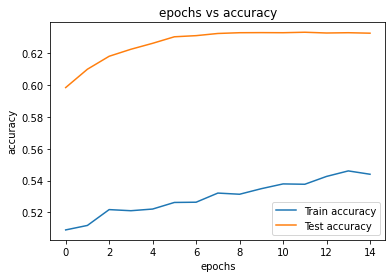

In [ ]:
plt.plot(train_accuracy_history, label='Train accuracy')
plt.plot(test_accuracy_history, label='Test accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("epochs vs accuracy")

Text(0.5, 1.0, 'epochs vs loss')

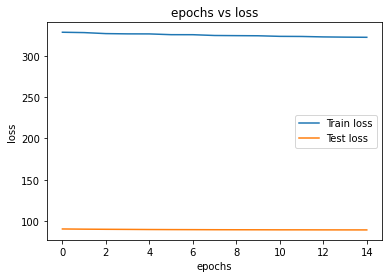

In [ ]:
plt.plot(train_loss_history, label='Train loss')
plt.plot(test_loss_history, label='Test loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("epochs vs loss")